In [163]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
import numpy as np
import nltk
import re
import datetime as dt
from PIL import Image
from collections import defaultdict
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
from glob import glob

In [2]:
songData = pd.read_pickle('songData_sorted.df')
# songData = songData.sort_values(by=['released'])

In [3]:
labMT = pd.read_csv('Hedonometer.csv', index_col='Rank')
happiness_score = {w: happiness for w, happiness in zip(labMT['Word'], labMT['Happiness Score'])}
words_with_score = set(w for w in labMT['Word'])

In [4]:
def idf(term: str, docs: {int: {str}}, log=np.log2):
    n = len(docs.keys())
    d = sum(term in doc for doc in docs.values())
    return log(n/d)

class MyColorFunctor():
    def __init__(self, tfidf):
        self.tfidf = tfidf
        self.high = max(tfidf.values())
        self.low = min(tfidf.values())

    def scale(self, x):
        return 260 - (x - self.low)/(self.high - self.low) * 200

    def __call__(self,word,font_size,position,orientation,random_state=None,**kwargs):
        return "hsl(%d, 80%%, %d%%)" % (self.scale(self.tfidf[word]), 50)

def text_happiness_score(token_list):
    text = [w for w in token_list if w in words_with_score]
    fdist = nltk.FreqDist(text)
    return sum([happiness_score[w] * fdist.freq(w) for w in set(text)])

def lexical_diversity(text):
    return len(set(text)) / len(text)

### Preprocessing the lyrics

In [5]:
# This has been done!

# Stopwords = set(w for w in stopwords.words('english'))
# lem_fun = WordNetLemmatizer()

# all_tokens = []
# all_tokens_repeat = []
# for t in songData.lyrics:
#     tokens = list(lem_fun.lemmatize(token.lower()) for token in nltk.word_tokenize(t) if token.isalpha() and lem_fun.lemmatize(token.lower()) not in Stopwords)
#     all_tokens_repeat.append(tokens)
#     all_tokens.append(list(set(tokens)))

# songData['tokens'] = all_tokens
# songData['tokens_repeat'] = all_tokens_repeat

## =======================   Genre   =======================

In [166]:
genre_count = defaultdict(lambda: 0)

for genres in songData.genres:
    for genre in genres:
        genre_count[genre] += 1

# Handpick genres
top_genres = ['pop', 'rock', 'rap', 'r&b', 'country', 'soul',
              'singer-songwriter', 'trap', 'ballad', 'uk',
             'hip-hop', 'funk', 'dance', 'electronic', 'folk',
             'jazz', 'blues']
N = len(top_genres)

# Choose top N genres containing most songs
# N = 20
# top_genres = set([k for k, v in sorted(genre_count.items(), key=lambda item: item[1], reverse=True)][:N])

In [167]:
len(genre_count)

582

In [36]:
genre_docs = defaultdict(lambda: [])

for tokens, genres in zip(songData.tokens, songData.genres):
    for genre in genres:
        genre_docs[genre] += tokens

top_genre_docs = {genre: doc for genre, doc in genre_docs.items() if genre in top_genres}

In [37]:
for genre, doc in top_genre_docs.items():
    print('='*50)
    print(genre)
    fdist = nltk.FreqDist(doc)
    N = len(doc)
    for word, count in fdist.most_common(5):
        print(f'     Occurrence of {word:<10}: {count/N}')
    print('')

pop
     Occurrence of know      : 0.010017684782595319
     Occurrence of love      : 0.009902001444811048
     Occurrence of oh        : 0.007727400829228011
     Occurrence of like      : 0.007680635224591816
     Occurrence of got       : 0.007155137509337738

folk
     Occurrence of know      : 0.008472360232205428
     Occurrence of like      : 0.00789707651273469
     Occurrence of time      : 0.0065373149939856705
     Occurrence of wa        : 0.0064327179540818995
     Occurrence of love      : 0.006275822394226243

blues
     Occurrence of know      : 0.009710982658959538
     Occurrence of oh        : 0.009595375722543353
     Occurrence of love      : 0.008323699421965317
     Occurrence of got       : 0.008208092485549132
     Occurrence of baby      : 0.008208092485549132

r&b
     Occurrence of know      : 0.00965643675281669
     Occurrence of love      : 0.008948995405760279
     Occurrence of oh        : 0.008280091719633011
     Occurrence of baby      : 0.007991059

In [127]:
top_genre_docs_set = {genre: set(doc) for genre, doc in top_genre_docs.items()}

all_terms = set()
for doc in top_genre_docs.values():
    all_terms = all_terms.union(set(doc))

idf_dict = {t: idf(t, top_genre_docs_set) for t in all_terms}

In [39]:
for genre, doc in top_genre_docs.items():
    print('='*50)
    print(genre)

    fdist = nltk.FreqDist(doc)
    N = len(doc)

    stock_tfidf = {t: fdist.freq(t) * idf_dict[t] for t in set(doc)}
    tfidf_keys = [k[0] for k in sorted(stock_tfidf.items(), key=lambda x: x[1], reverse=True)[:10]]

    print(f'{"TF":>14} {"TFIDF":>25}')
    i = 1
    for (tf_word, _), iftdf_word in zip(fdist.most_common(10), tfidf_keys[:10]):
        print(f'{str(i)+".":<4} {tf_word:<8} {_/N:.4f} {iftdf_word:>17} {stock_tfidf[iftdf_word]:.5f}')
        i += 1
    print('')

pop
            TF                     TFIDF
1.   know     0.0100            chorus 0.00008
2.   love     0.0099     miscellaneous 0.00006
3.   oh       0.0077            broken 0.00006
4.   like     0.0077             party 0.00005
5.   got      0.0072          breaking 0.00005
6.   time     0.0070           breathe 0.00005
7.   go       0.0066           rainbow 0.00005
8.   one      0.0063            happen 0.00005
9.   na       0.0062             nigga 0.00005
10.  see      0.0062              fear 0.00005

folk
            TF                     TFIDF
1.   know     0.0085      annihilation 0.00032
2.   like     0.0079        squandered 0.00026
3.   time     0.0065            ragged 0.00024
4.   wa       0.0064            sunlit 0.00022
5.   love     0.0063            knowed 0.00022
6.   one      0.0057             birch 0.00022
7.   come     0.0056             canal 0.00018
8.   go       0.0055        suppertime 0.00018
9.   say      0.0052         hitchhike 0.00018
10.  day      0

### Wordcloud

In [156]:
from PIL import Image
  
def convertImage(file):
    img = Image.open(file)
    img = img.convert("RGBA")
  
    datas = img.getdata()
  
    newData = []
  
    for item in datas:
        if item[0] == 255 and item[1] == 255 and item[2] == 255:
            newData.append((255, 255, 255, 0))
        else:
            newData.append(item)
  
    img.putdata(newData)
    return img
  

In [160]:
genres_with_im = ['pop', 'rock', 'rap', 'folk', 'blues', 'country', 'uk', 'funk', 'r&b']
genre_ims = {genre: np.array(Image.open(f"wordcloud_masks/genres/{genre}.jpg")) for genre in top_genre_docs.keys() if genre in genres_with_im}

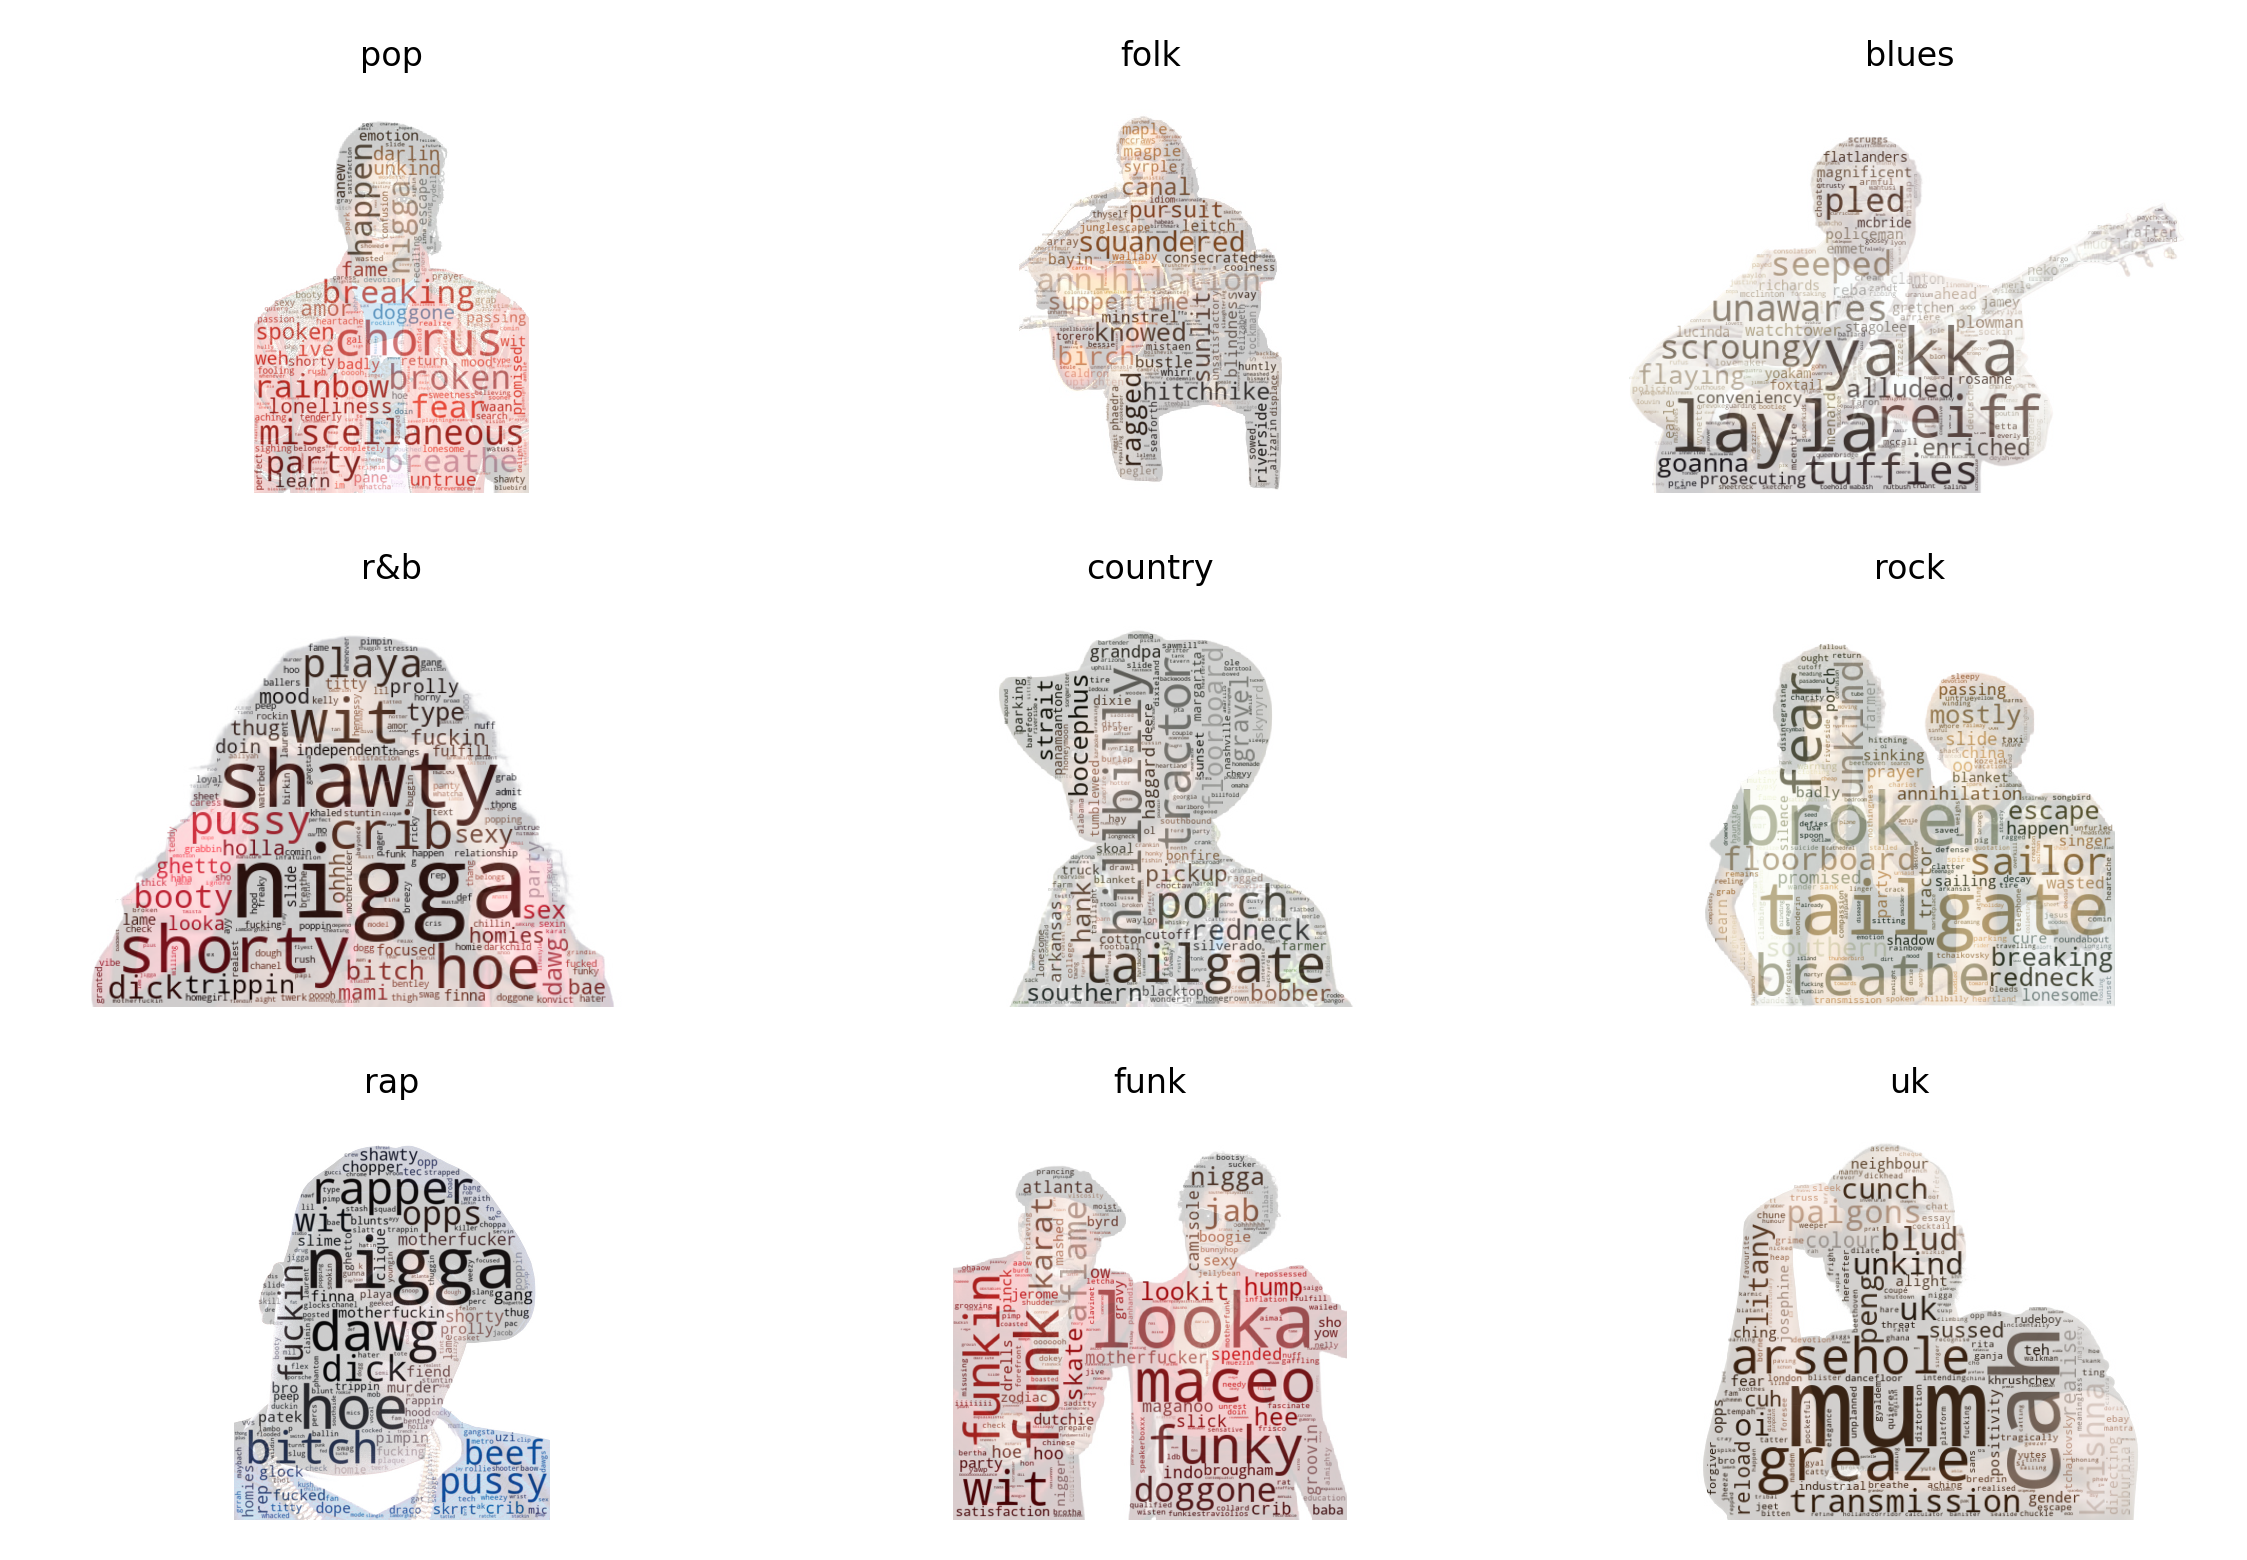

In [162]:
plt.figure(dpi=400)
my_cmap = copy.copy(plt.cm.get_cmap('gray'))
my_cmap.set_bad(alpha=0)
for i, genre in enumerate(genre_ims.keys()):
    fdist = nltk.FreqDist(genre_docs[genre])
    genre_tfidf = {t: fdist.freq(t) * idf_dict[t] for t in set(genre_docs[genre])}
    wc = WordCloud(mode='RGBA', background_color=None, mask=genre_ims[genre])
    wc.generate_from_frequencies(genre_tfidf)
    image_colors = ImageColorGenerator(genre_ims[genre])
    plt.subplot(3, 3, i+1)
    plt.imshow(wc.recolor(color_func=image_colors), interpolation='bilinear')
    im = convertImage(f"wordcloud_masks/genres/{genre}.jpg")
    plt.imshow(im, interpolation='nearest', alpha=0.2)
    plt.title(genre, fontsize=6)
    plt.axis("off")
plt.tight_layout()
plt.savefig('../static/images/genre_clouds.png', bbox_inches='tight')
plt.show()

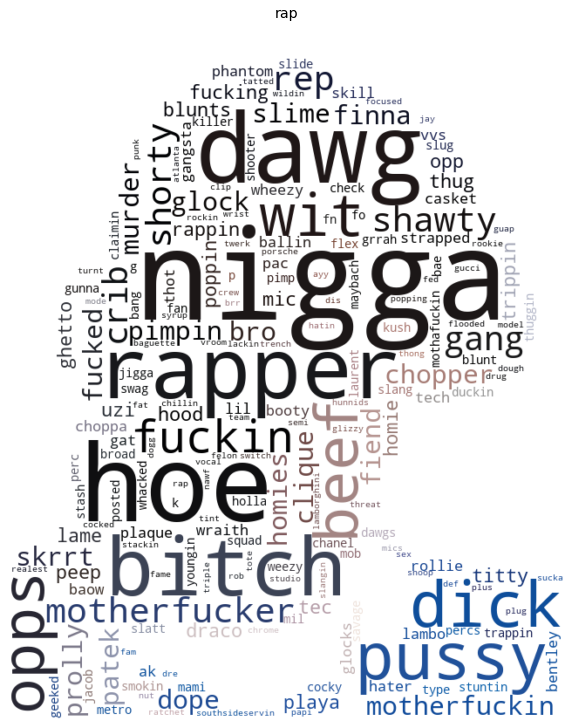

In [43]:
# n_decades = len(decade_docs.keys())

# gs = gridspec.GridSpec(2, n_decades+1)
for i, genre in enumerate(genre_ims.keys()):
    fdist = nltk.FreqDist(genre_docs[genre])
    genre_tfidf = {t: fdist.freq(t) * idf_dict[t] for t in set(genre_docs[genre])}
    wc = WordCloud(background_color='white', mask=genre_ims[genre]) # , color_func=MyColorFunctor(decade_tfidf)
    wc.generate_from_frequencies(genre_tfidf)
    image_colors = ImageColorGenerator(genre_ims[genre])
#     if i < ((n_decades+1)//2):
#         ax = plt.subplot(gs[0, 2 * i:2 * i + 2])
#     else:
#         ax = plt.subplot(gs[1, 2 * i - n_decades:2 * i + 2 - n_decades])
    plt.figure(figsize=(10,15))
    plt.imshow(wc.recolor(color_func=image_colors), interpolation='bilinear')
    plt.title(genre, size='x-large')
    plt.axis("off")
    plt.show()

### Sentiment analysis

In [44]:
genre_happiness = {}

for genre, doc in top_genre_docs.items():
    genre_happiness[genre] = text_happiness_score(doc)
    print(genre, end=' ')
    
genre_happiness = {k: v for k, v in sorted(genre_happiness.items(), key=lambda item: item[1], reverse=True)}

pop folk blues r&b jazz country rock singer-songwriter soul rap ballad funk uk trap dance hip-hop electronic 

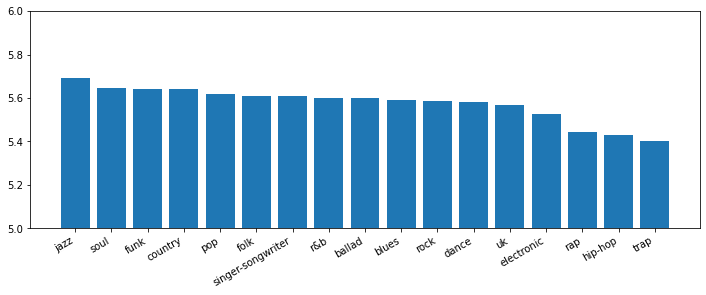

In [45]:
plt.figure(figsize=(12,4))
plt.bar(*zip(*genre_happiness.items()))
plt.xticks(rotation=30, ha='right')
plt.ylim(5,6)
plt.show()

### Dispersion plot

In [63]:
# Taken directly from nltk. Modified to allow for custom xticks.
def dispersion_plot(text, words, ignore_case=False, title="Lexical Dispersion Plot", xticks=None):
    """
    Generate a lexical dispersion plot.

    :param text: The source text
    :type text: list(str) or enum(str)
    :param words: The target words
    :type words: list of str
    :param ignore_case: flag to set if case should be ignored when searching text
    :type ignore_case: bool
    """

    try:
        from matplotlib import pylab
    except ImportError as e:
        raise ValueError(
            "The plot function requires matplotlib to be installed."
            "See https://matplotlib.org/"
        ) from e

    text = list(text)
    words.reverse()

    if ignore_case:
        words_to_comp = list(map(str.lower, words))
        text_to_comp = list(map(str.lower, text))
    else:
        words_to_comp = words
        text_to_comp = text

    points = [
        (x, y)
        for x in range(len(text_to_comp))
        for y in range(len(words_to_comp))
        if text_to_comp[x] == words_to_comp[y]
    ]
    if points:
        x, y = list(zip(*points))
    else:
        x = y = ()
    pylab.plot(x, y, "b|", scalex=0.1)
    pylab.yticks(list(range(len(words))), words, color="b")
    pylab.ylim(-1, len(words))
    pylab.title(title)
    pylab.xlabel("Word Offset")
    if xticks is not None:
        pylab.xticks(*zip(*decade_tick.items()))
    pylab.show()

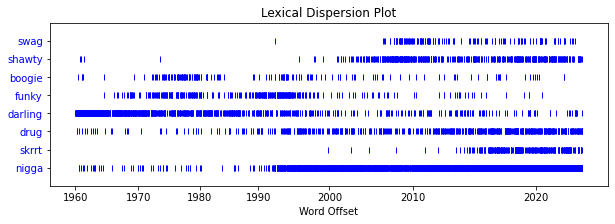

In [124]:
all_tokens = []
decade_tick = {0: 1960}
ny = 1970
for release, tokens in zip(songData.released, songData.tokens):
    all_tokens += tokens
    year = int(release[:4])
    if year >= ny:
        decade_tick[len(all_tokens)] = ny
        ny += 10

words = nltk.Text(all_tokens)
plt.figure(figsize=(10,3))
dispersion_plot(words, ['swag', 'shawty', 'boogie', 'funky', 'darling', 'drug', 'skrrt', 'nigga'], xticks=decade_tick)

## =======================   Decade   =======================

In [27]:
top_genres = ['pop', 'rock', 'rap', 'r&b', 'country', 'soul',
              'singer-songwriter', 'trap', 'ballad', 'uk',
              'funk', 'electronic', 'jazz', 'blues']
# 'hip-hop', 'folk'

In [99]:
decade_docs = defaultdict(lambda: [])
decade_genre_count = defaultdict(lambda: defaultdict(lambda: 0))
genre_decade_docs = defaultdict(lambda: defaultdict(lambda: []))
decade_genre_df = pd.DataFrame(None, columns=top_genres)
percentage_df = pd.DataFrame(None, columns=top_genres)
decade_genre_list = {decade: [0]*len(top_genres) for decade in range(1960, 2021, 10)}

for tokens, release, genres in zip(songData.tokens, songData.released, songData.genres):
    decade = max(int(int(release[:4]) / 10) * 10, 1960)
    decade_docs[decade] += tokens
    for genre in genres:
        decade_genre_count[decade][genre] += 1
        genre_decade_docs[genre][decade] += tokens
    for i, genre in enumerate(top_genres):
        if genre in genres:
            decade_genre_list[decade][i] += 1

for decade, counts in decade_genre_list.items():
    decade_genre_df.loc[decade] = decade_genre_list[decade]
    decade_count = sum(decade_genre_list[decade])
    percentage_df.loc[decade] = [c/decade_count for c in decade_genre_list[decade]]

decade_docs = {k: v for k, v in sorted(decade_docs.items(), key=lambda item: int(item[0]))}

In [29]:
decade_genre_df

pop  rock   rap  r&b country soul singer-songwriter trap ballad   uk  \
1960  3713   909    64  753     382  506                86    2     71  102   
1970  2569  1268    43  844     375  582               288    0    192  165   
1980  2482  1231   103  606     102  287               250    0    174  248   
1990  1453   621   700  763     229  309               138    2    163  103   
2000  1241   937  1004  748     613  218               304   31    287   64   
2010  1814   650  2011  873     760  129               482  848    427  242   
2020   431    72   851  254     155   39               189  571     95   47   

     funk electronic jazz blues  
1960   94          0   69    58  
1970  293          3   24    34  
1980  199         37   29    13  
1990   60         72   13     7  
2000   48         70   14    15  
2010   45        301   19    20  
2020   13         61    4     2

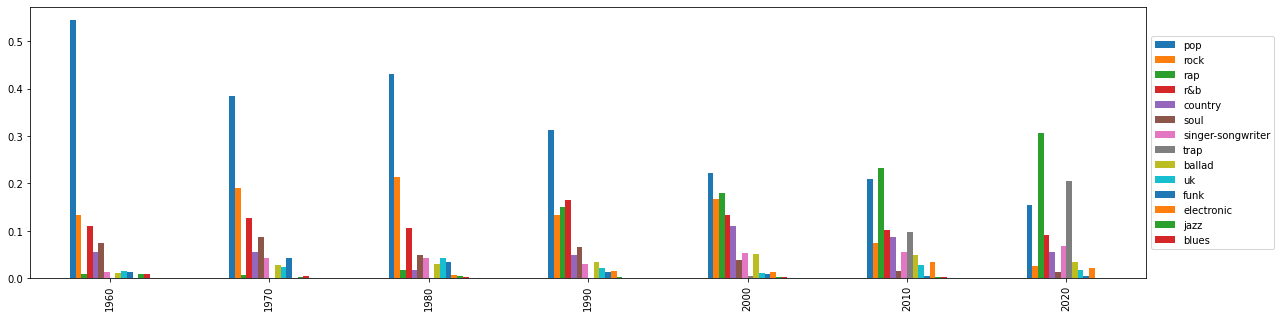

In [30]:
f = plt.figure()
percentage_df.plot.bar(figsize=(20,5), ax=f.gca())
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

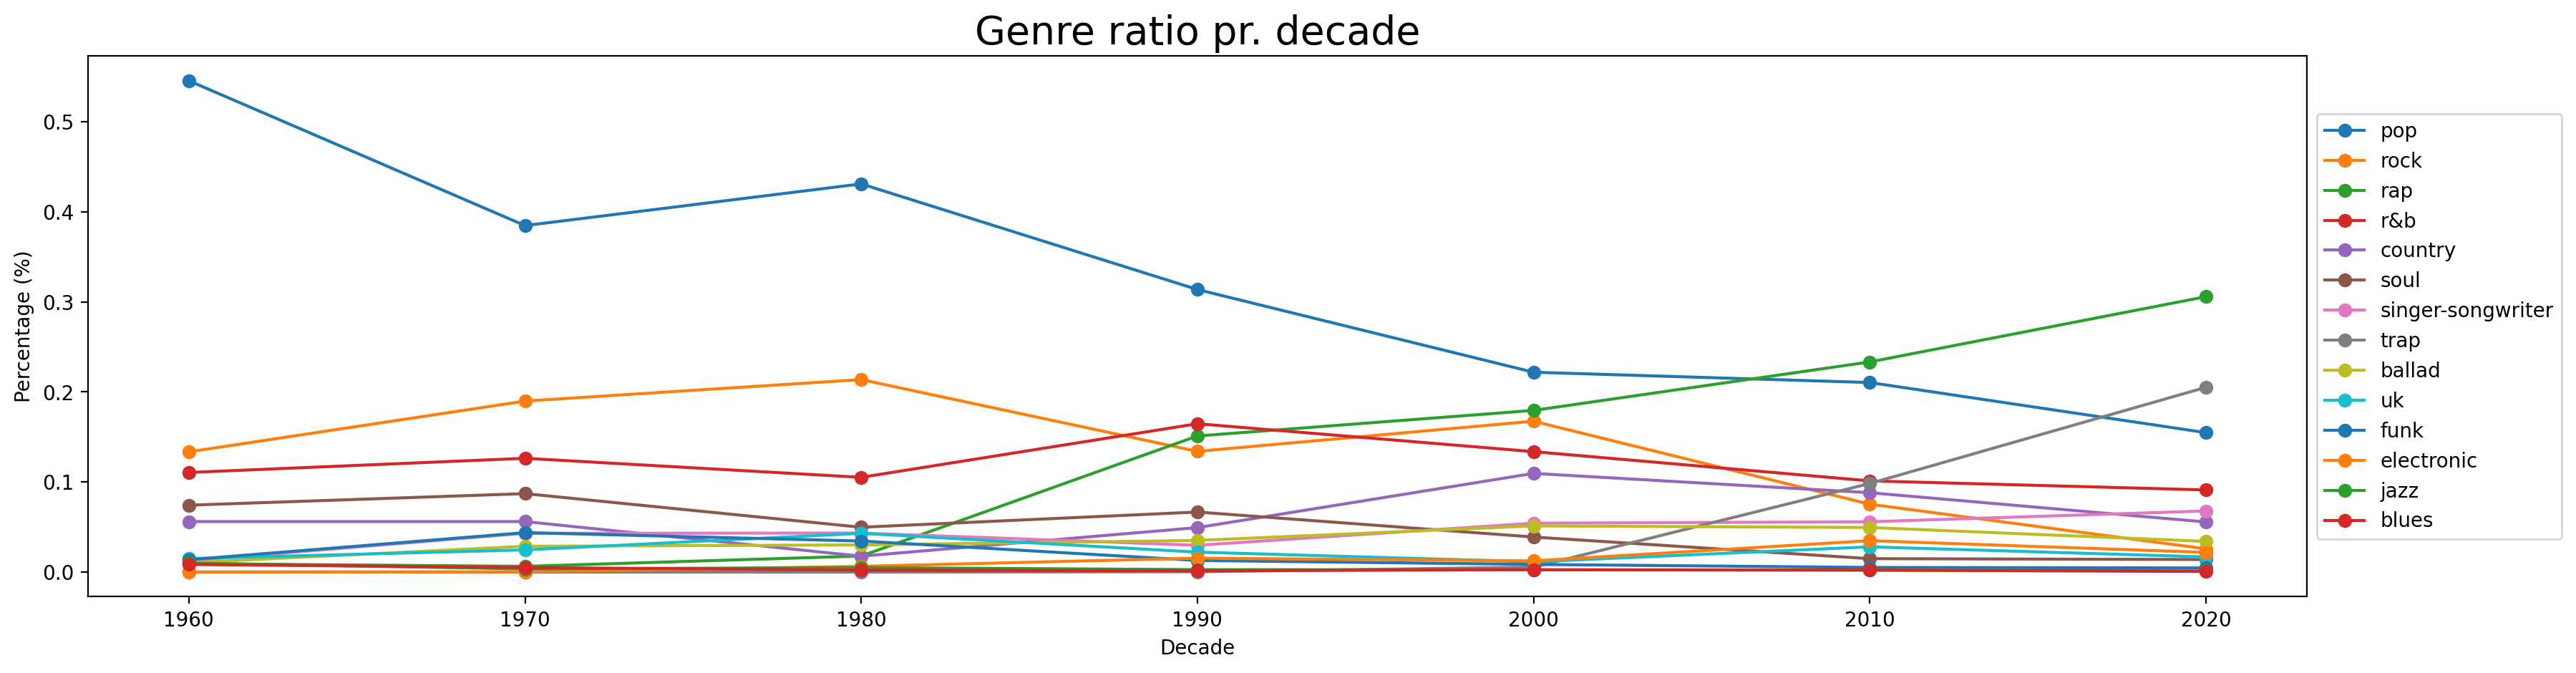

In [35]:
plt.figure(figsize=(20,5), dpi=200)
n_decades = len(percentage_df)
for col in percentage_df.columns:
    plt.plot(range(n_decades), percentage_df[col], 'o-', label=col)
plt.title('Genre ratio pr. decade', size=20)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xticks(range(n_decades), decade_docs.keys())
plt.xlabel('Decade')
plt.ylabel('Percentage (%)')
plt.show()

In [32]:
for decade, doc in decade_docs.items():
    print('='*50)
    print(decade)
    fdist = nltk.FreqDist(doc)
    N = len(doc)
    for word, count in fdist.most_common(5):
        print(f'     Occurrence of {word:<10}: {count/N}')
    print('')

1960
     Occurrence of love      : 0.012231131267486154
     Occurrence of know      : 0.010281654526619739
     Occurrence of oh        : 0.008303628963188333
     Occurrence of go        : 0.006876187834938864
     Occurrence of got       : 0.006855795818821015

1970
     Occurrence of know      : 0.009869426978388636
     Occurrence of love      : 0.009785645764650193
     Occurrence of got       : 0.007862866909352915
     Occurrence of oh        : 0.007841921605918305
     Occurrence of like      : 0.007280587473870734

1980
     Occurrence of know      : 0.009988930589060247
     Occurrence of love      : 0.009764014271160876
     Occurrence of time      : 0.007801509144391866
     Occurrence of got       : 0.007444289110081102
     Occurrence of oh        : 0.007192912048899453

1990
     Occurrence of know      : 0.007627508262832278
     Occurrence of love      : 0.006599405582887159
     Occurrence of like      : 0.0063822007913494575
     Occurrence of time      : 0.0059550

In [13]:
N = len(decade_docs.keys())

decade_docs_set = {decade: set(doc) for decade, doc in decade_docs.items()}

all_terms = set()
for doc in decade_docs.values():
    all_terms = all_terms.union(set(doc))

idf_dict = {t: idf(t, decade_docs_set) for t in all_terms}

In [14]:
for decade, doc in decade_docs.items():
    print('='*50)
    print(decade)

    fdist = nltk.FreqDist(doc)
    N = len(doc)

    stock_tfidf = {t: fdist.freq(t) * idf_dict[t] for t in set(doc)}
    tfidf_keys = [k[0] for k in sorted(stock_tfidf.items(), key=lambda x: x[1], reverse=True)[:10]]

    print(f'{"TF":>14} {"TFIDF":>25}')
    i = 1
    for (tf_word, _), iftdf_word in zip(fdist.most_common(10), tfidf_keys[:10]):
        print(f'{str(i)+".":<4} {tf_word:<8} {_/N:.4f} {iftdf_word:>17} {stock_tfidf[iftdf_word]:.5f}')
        i += 1
    print('')

1960
            TF                     TFIDF
1.   love     0.0122            watusi 0.00011
2.   know     0.0103          tenderly 0.00009
3.   oh       0.0083             looka 0.00007
4.   go       0.0069            sighin 0.00007
5.   got      0.0069             hully 0.00006
6.   like     0.0068            billow 0.00006
7.   come     0.0067             rovin 0.00006
8.   one      0.0066            fickle 0.00005
9.   baby     0.0065             twine 0.00005
10.  time     0.0064           doggone 0.00005

1970
            TF                     TFIDF
1.   know     0.0099            nigger 0.00006
2.   love     0.0098           doggone 0.00005
3.   got      0.0079        gentleness 0.00005
4.   oh       0.0078              toad 0.00004
5.   like     0.0073            unkind 0.00004
6.   time     0.0071               uum 0.00004
7.   get      0.0065          marianne 0.00004
8.   come     0.0063           crowing 0.00004
9.   go       0.0062            salina 0.00004
10.  na       

### LOOKING AT GENRE TFIDF PR DECADE

In [101]:
for genre in ['rap', 'pop', 'rock', 'r&b', 'country']:
    
    print('='*100)
    print('='*100)
    print(genre)
    print('='*100)
    print('='*100)
    genre_decade_docs_set = {decade: set(doc) for decade, doc in genre_decade_docs[genre].items()}
    
    all_terms = set()
    for doc in genre_decade_docs[genre].values():
        all_terms = all_terms.union(set(doc))

    idf_dict = {t: idf(t, genre_decade_docs_set) for t in all_terms}
    for decade, doc in genre_decade_docs[genre].items():
        print('='*50)
        print(decade)
        fdist = nltk.FreqDist(doc)
        N = len(doc)
        stock_tfidf = {t: fdist.freq(t) * idf_dict[t] for t in set(doc)}
        tfidf_keys = [k[0] for k in sorted(stock_tfidf.items(), key=lambda x: x[1], reverse=True)[:10]]

        print(f'{"TF":>14} {"TFIDF":>25}')
        i = 1
        for (tf_word, _), iftdf_word in zip(fdist.most_common(10), tfidf_keys[:10]):
            print(f'{str(i)+".":<4} {tf_word:<8} {_/N:.4f} {iftdf_word:>17} {stock_tfidf[iftdf_word]:.5f}')
            i += 1
        print('')

rap
1960
            TF                     TFIDF
1.   got      0.0042             imani 0.00042
2.   like     0.0041             runna 0.00042
3.   get      0.0039         communist 0.00042
4.   know     0.0036          fleeting 0.00042
5.   back     0.0034        everynight 0.00042
6.   go       0.0032            curren 0.00042
7.   na       0.0030              tile 0.00042
8.   one      0.0030         busdriver 0.00042
9.   right    0.0030           barnett 0.00042
10.  time     0.0029        highschool 0.00042

1970
            TF                     TFIDF
1.   like     0.0040           spastic 0.00039
2.   got      0.0040      unauthorized 0.00038
3.   get      0.0037                uv 0.00038
4.   know     0.0032             youll 0.00038
5.   wa       0.0030           shiesty 0.00038
6.   never    0.0030     consideration 0.00038
7.   go       0.0029           amistad 0.00038
8.   take     0.0028           trinnnn 0.00030
9.   time     0.0028            adlibs 0.00030
10.  back 

            TF                     TFIDF
1.   know     0.0093              cock 0.00032
2.   like     0.0081              free 0.00028
3.   one      0.0068            trying 0.00026
4.   time     0.0067             bring 0.00019
5.   love     0.0067           revolve 0.00019
6.   go       0.0063            option 0.00019
7.   got      0.0063             caged 0.00019
8.   never    0.0061       suffocating 0.00019
9.   get      0.0060         imitation 0.00019
10.  say      0.0059               arm 0.00016

2010
            TF                     TFIDF
1.   like     0.0080          tailgate 0.00039
2.   know     0.0078            trying 0.00025
3.   got      0.0069             kanye 0.00024
4.   go       0.0065              jeff 0.00024
5.   love     0.0062           redneck 0.00023
6.   time     0.0061           sipping 0.00023
7.   get      0.0059          chemical 0.00023
8.   one      0.0058              free 0.00022
9.   yeah     0.0058              wind 0.00022
10.  let      0.005

### Word cloud

In [49]:
decade_ims = {decade: np.array(Image.open(f"../{decade}.png")) for decade in decade_docs.keys()}

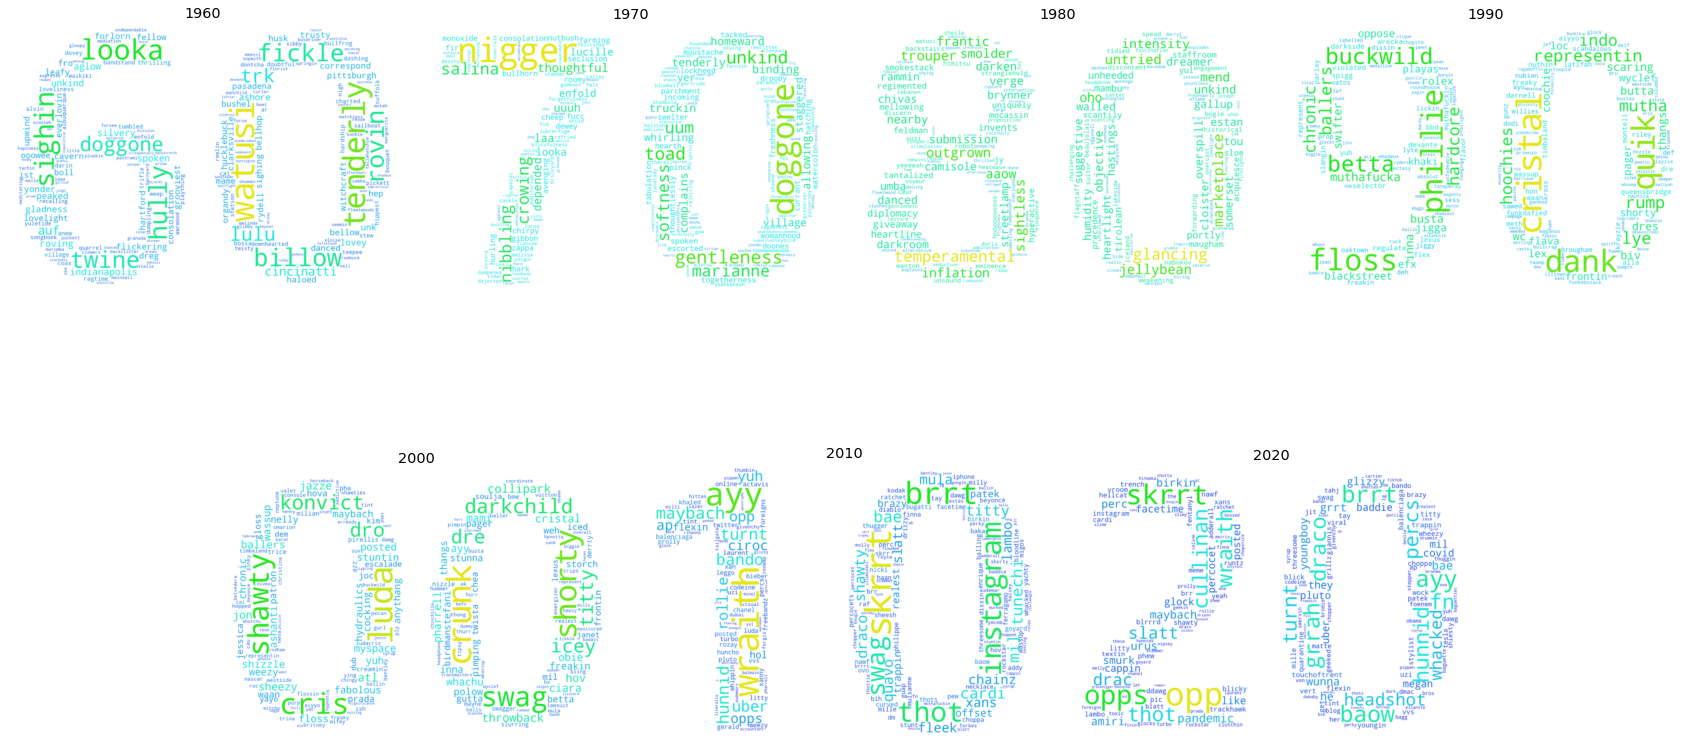

In [47]:
n_decades = len(decade_docs.keys())
plt.figure(figsize=(30,15))
gs = gridspec.GridSpec(2, n_decades+1)
for i, (decade, doc) in enumerate(decade_docs.items()):
    fdist = nltk.FreqDist(doc)
    decade_tfidf = {t: fdist.freq(t) * idf_dict[t] for t in set(doc)}
    wordcloud = WordCloud(background_color='white', mask=decade_ims[decade], color_func=MyColorFunctor(decade_tfidf))
    wordcloud.generate_from_frequencies(decade_tfidf)
    
    if i < ((n_decades+1)//2):
        ax = plt.subplot(gs[0, 2 * i:2 * i + 2])
    else:
        ax = plt.subplot(gs[1, 2 * i - n_decades:2 * i + 2 - n_decades])
    
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(decade, size='x-large')
    plt.axis("off")
plt.show()

### Sentiment analysis

In [66]:
decade_happiness = {}

for decade, doc in decade_docs.items():
    decade_happiness[decade] = text_happiness_score(doc)
    print(decade, end=' ')

1960 1970 1980 1990 2000 2010 2020 

In [67]:
plt.figure(figsize=(12,4))
plt.bar(*zip(*decade_happiness.items()))
plt.xticks(rotation=30, ha='right')
plt.ylim(5,6)
plt.show()

{1960: 5.653644708709559,
 1970: 5.667815146426225,
 1980: 5.604704215573121,
 1990: 5.543409526642222,
 2000: 5.535554258525407,
 2010: 5.49120864337768,
 2020: 5.427076590096197}

# Year

In [7]:
month_docs = defaultdict(lambda: [])
for tokens, release in zip(songData.tokens, songData.released):
    if len(release) == 4 or int(release[:4]) < 1960:
        continue
    month_docs[release[:7]] += tokens

### Sentiment

In [21]:
dates = [np.datetime64(month) for month in month_docs.keys()]
month_happiness = [text_happiness_score(doc) for doc in month_docs.values()]
month_happiness = pd.Series(month_happiness, index=dates)

In [18]:
dates

[numpy.datetime64('1960-01'),
 numpy.datetime64('1960-02'),
 numpy.datetime64('1960-03'),
 numpy.datetime64('1960-04'),
 numpy.datetime64('1960-05'),
 numpy.datetime64('1960-06'),
 numpy.datetime64('1960-07'),
 numpy.datetime64('1960-08'),
 numpy.datetime64('1960-09'),
 numpy.datetime64('1960-10'),
 numpy.datetime64('1960-11'),
 numpy.datetime64('1960-12'),
 numpy.datetime64('1961-01'),
 numpy.datetime64('1961-02'),
 numpy.datetime64('1961-03'),
 numpy.datetime64('1961-04'),
 numpy.datetime64('1961-05'),
 numpy.datetime64('1961-06'),
 numpy.datetime64('1961-07'),
 numpy.datetime64('1961-08'),
 numpy.datetime64('1961-09'),
 numpy.datetime64('1961-10'),
 numpy.datetime64('1961-11'),
 numpy.datetime64('1961-12'),
 numpy.datetime64('1962-01'),
 numpy.datetime64('1962-02'),
 numpy.datetime64('1962-03'),
 numpy.datetime64('1962-04'),
 numpy.datetime64('1962-05'),
 numpy.datetime64('1962-06'),
 numpy.datetime64('1962-07'),
 numpy.datetime64('1962-08'),
 numpy.datetime64('1962-09'),
 numpy.dat

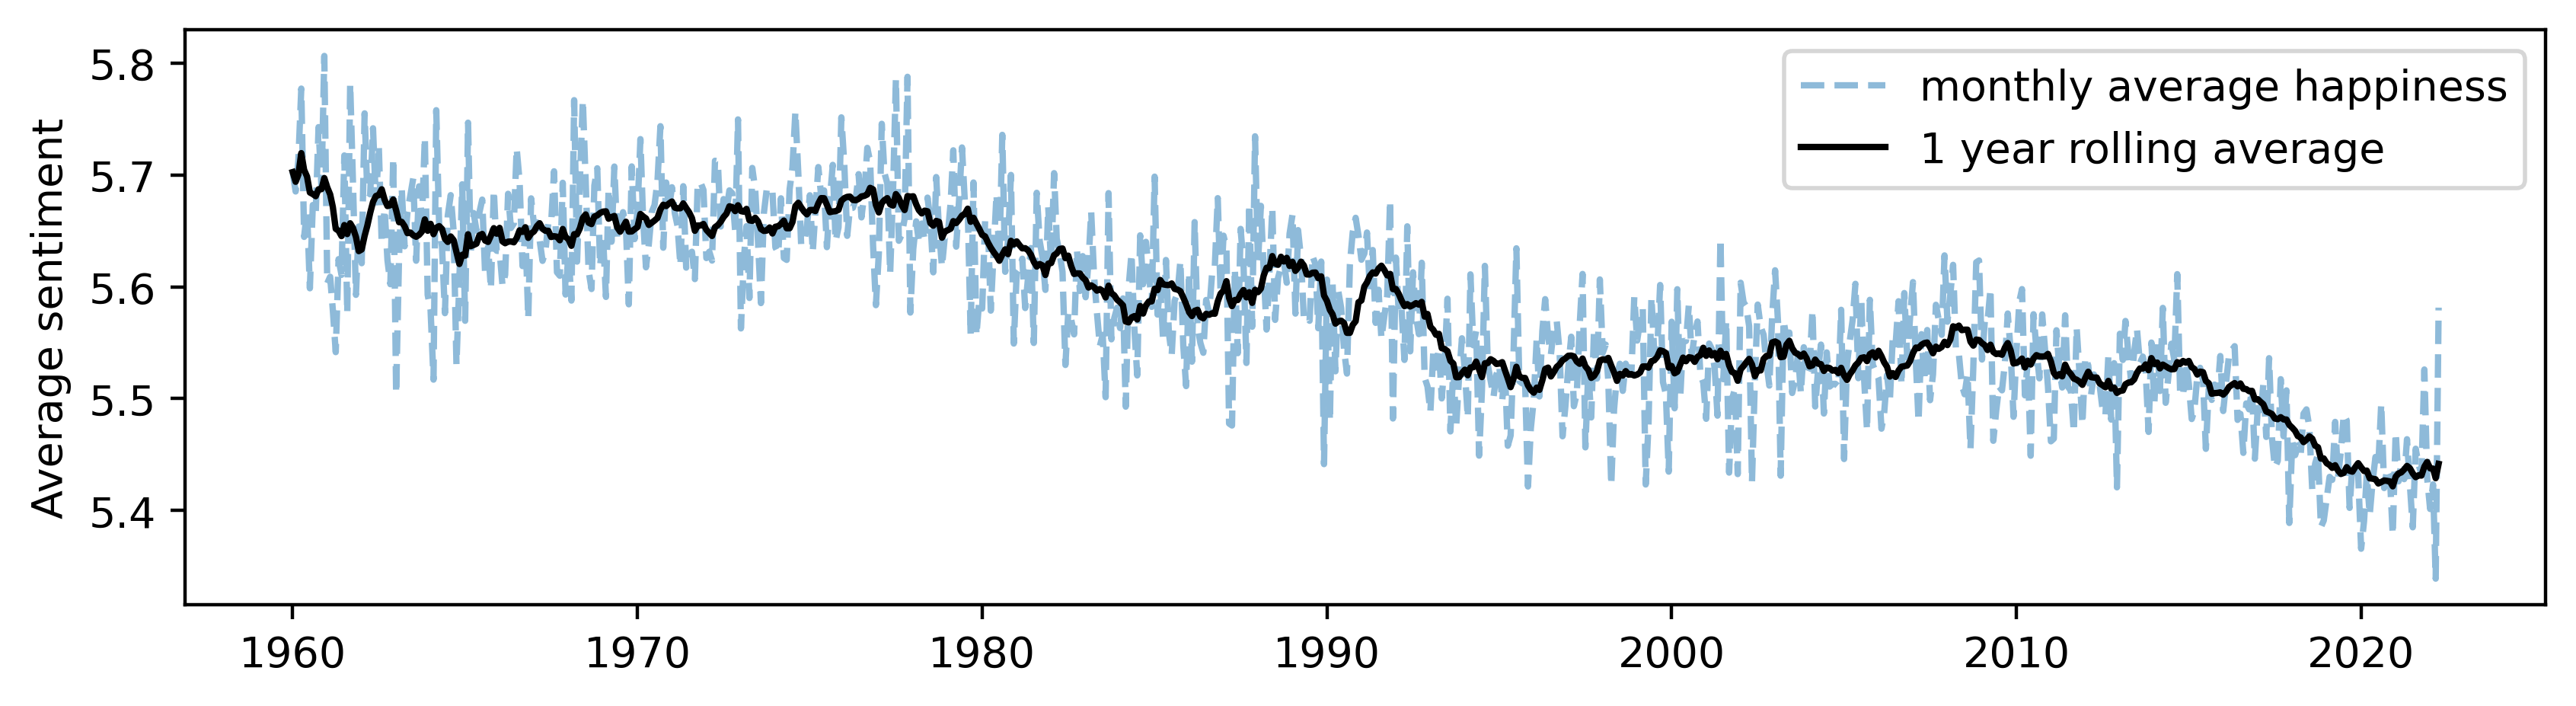

In [25]:
rolled_series = month_happiness.rolling("365D").mean()

myFmt = mdates.DateFormatter("%Y")
fig, ax = plt.subplots(figsize=(10,2.5), dpi=400)
ax.plot(month_happiness.index, month_happiness.values, ls = "--", alpha = 0.5, label = "monthly average happiness")
ax.plot(rolled_series.index, rolled_series.values, color = "k", label = "1 year rolling average")
ax.set_ylabel("Average sentiment")
ax.legend()
ax.xaxis.set_major_formatter(myFmt)

# Artist

In [79]:
artist_count = defaultdict(lambda: 0)

for artists in songData.artists:
    for artist in artists:
        artist_count[artist] += 1
artist_count = {k: v for k, v in sorted(artist_count.items(), key=lambda item: item[1], reverse=True)}

top_artists = list(artist for artist, count in artist_count.items() if count > 25)

In [80]:
artist_docs = defaultdict(lambda: [])

for tokens, artists in zip(songData.tokens, songData.artists):
    for artist in artists:
        artist_docs[artist] += tokens

top_artist_docs = {artist: doc for artist, doc in artist_docs.items() if artist in top_artists}

In [81]:
for artist, doc in top_artist_docs.items():
    print('='*50)
    print(artist)
    fdist = nltk.FreqDist(doc)
    N = len(doc)
    for word, count in fdist.most_common(5):
        print(f'     Occurrence of {word:<10}: {count/N}')
    print('')

frank sinatra
     Occurrence of love      : 0.01072234762979684
     Occurrence of like      : 0.009593679458239277
     Occurrence of heart     : 0.009029345372460496
     Occurrence of come      : 0.009029345372460496
     Occurrence of go        : 0.007900677200902935

the drifters
     Occurrence of oh        : 0.018326693227091632
     Occurrence of know      : 0.013545816733067729
     Occurrence of like      : 0.010358565737051793
     Occurrence of baby      : 0.010358565737051793
     Occurrence of love      : 0.009561752988047808

elvis presley
     Occurrence of love      : 0.013214739517153748
     Occurrence of know      : 0.010673443456162644
     Occurrence of like      : 0.008386277001270648
     Occurrence of go        : 0.008132147395171537
     Occurrence of oh        : 0.007878017789072427

ricky nelson
     Occurrence of love      : 0.014522821576763486
     Occurrence of know      : 0.012448132780082987
     Occurrence of see       : 0.009681881051175657
     Occ

     Occurrence of know      : 0.005654557916381083
     Occurrence of like      : 0.0054832076764907475
     Occurrence of got       : 0.0054832076764907475
     Occurrence of go        : 0.005311857436600411
     Occurrence of get       : 0.005311857436600411

eminem
     Occurrence of like      : 0.0038423733357162006
     Occurrence of got       : 0.0037976945759985704
     Occurrence of get       : 0.00375301581628094
     Occurrence of know      : 0.0036189795371280495
     Occurrence of go        : 0.003395585738539898

timbaland
     Occurrence of got       : 0.007814942169427946
     Occurrence of get       : 0.007502344482650828
     Occurrence of like      : 0.00718974679587371
     Occurrence of yeah      : 0.006877149109096593
     Occurrence of see       : 0.006564551422319475

kenny chesney
     Occurrence of got       : 0.007554945054945055
     Occurrence of like      : 0.007097069597069597
     Occurrence of one       : 0.006868131868131868
     Occurrence of back    

     Occurrence of like      : 0.004862039625622949
     Occurrence of nigga     : 0.004618937644341801
     Occurrence of got       : 0.004618937644341801
     Occurrence of get       : 0.004618937644341801
     Occurrence of bitch     : 0.004375835663060654

travis scott
     Occurrence of yeah      : 0.006572341396622547
     Occurrence of like      : 0.006389776357827476
     Occurrence of got       : 0.005842081241442264
     Occurrence of know      : 0.005659516202647193
     Occurrence of get       : 0.005294386125057051

young thug
     Occurrence of yeah      : 0.005813953488372093
     Occurrence of like      : 0.005813953488372093
     Occurrence of got       : 0.005813953488372093
     Occurrence of bitch     : 0.005642954856361149
     Occurrence of nigga     : 0.005300957592339261

xxxtentacion
     Occurrence of like      : 0.00944386149003148
     Occurrence of yeah      : 0.008919202518363064
     Occurrence of na        : 0.007869884575026232
     Occurrence of feel  

In [82]:
top_artist_docs_set = {artist: set(doc) for artist, doc in top_artist_docs.items()}

all_terms = set()
for doc in top_artist_docs.values():
    all_terms = all_terms.union(set(doc))

idf_dict = {t: idf(t, top_artist_docs_set) for t in all_terms}

In [83]:
for artist, doc in top_artist_docs.items():
    print('='*50)
    print(artist)

    fdist = nltk.FreqDist(doc)
    N = len(doc)

    stock_tfidf = {t: fdist.freq(t) * idf_dict[t] for t in set(doc)}
    tfidf_keys = [k[0] for k in sorted(stock_tfidf.items(), key=lambda x: x[1], reverse=True)[:10]]

    print(f'{"TF":>14} {"TFIDF":>25}')
    i = 1
    for (tf_word, _), iftdf_word in zip(fdist.most_common(10), tfidf_keys[:10]):
        print(f'{str(i)+".":<4} {tf_word:<8} {_/N:.4f} {iftdf_word:>17} {stock_tfidf[iftdf_word]:.5f}')
        i += 1
    print('')

frank sinatra
            TF                     TFIDF
1.   love     0.0107          carousel 0.00531
2.   like     0.0096           musical 0.00531
3.   heart    0.0090         interlude 0.00510
4.   come     0.0090         reminding 0.00490
5.   go       0.0079           perhaps 0.00473
6.   wa       0.0079            sleigh 0.00431
7.   know     0.0079            autumn 0.00431
8.   never    0.0073           goldang 0.00424
9.   day      0.0073          cabanera 0.00424
10.  time     0.0068             miser 0.00424

the drifters
            TF                     TFIDF
1.   oh       0.0183         boardwalk 0.00786
2.   know     0.0135           sighing 0.00720
3.   like     0.0104          hacienda 0.00599
4.   baby     0.0104         trickling 0.00599
5.   love     0.0096       cinemascope 0.00599
6.   na       0.0096        generously 0.00599
7.   yeah     0.0080           tighter 0.00521
8.   night    0.0080         fireproof 0.00519
9.   ca       0.0080          moonbeam 0.005

            TF                     TFIDF
1.   know     0.0083              soho 0.00604
2.   get      0.0083             sewer 0.00604
3.   got      0.0077          ecstatic 0.00604
4.   like     0.0077            donkey 0.00538
5.   never    0.0064           ransack 0.00482
6.   love     0.0058           prevent 0.00482
7.   feel     0.0058          brighton 0.00482
8.   think    0.0058            silken 0.00482
9.   come     0.0058            hiwatt 0.00482
10.  one      0.0051        glittering 0.00482

b.j. thomas
            TF                     TFIDF
1.   love     0.0169        discovered 0.00700
2.   time     0.0105           sombody 0.00606
3.   know     0.0097           catlady 0.00606
4.   see      0.0089      strengthened 0.00606
5.   like     0.0089            leauge 0.00606
6.   oh       0.0081           patched 0.00606
7.   come     0.0073          raindrop 0.00552
8.   old      0.0073          montreal 0.00525
9.   never    0.0073              whem 0.00525
10.  got    

            TF                     TFIDF
1.   like     0.0038             shady 0.00380
2.   got      0.0038               dre 0.00372
3.   get      0.0038            hailie 0.00336
4.   know     0.0036              shit 0.00310
5.   go       0.0034            fuckin 0.00308
6.   back     0.0033              fuck 0.00305
7.   say      0.0033          marshall 0.00303
8.   yeah     0.0033             bitch 0.00253
9.   wa       0.0032           mathers 0.00238
10.  fuck     0.0032              slim 0.00229

timbaland
            TF                     TFIDF
1.   got      0.0078         timbaland 0.00951
2.   get      0.0075           maganoo 0.00611
3.   like     0.0072             missy 0.00596
4.   yeah     0.0069             timbo 0.00517
5.   see      0.0066       promiscuous 0.00407
6.   go       0.0066               uhh 0.00405
7.   need     0.0063            jiving 0.00345
8.   girl     0.0063          ginuwine 0.00308
9.   want     0.0063             strut 0.00262
10.  na       

            TF                     TFIDF
1.   like     0.0066              tyga 0.00915
2.   got      0.0064             nigga 0.00615
3.   get      0.0058             bitch 0.00478
4.   yeah     0.0056             pussy 0.00451
5.   na       0.0054              shit 0.00405
6.   ai       0.0054              fuck 0.00399
7.   nigga    0.0054              dick 0.00341
8.   make     0.0052               ayy 0.00302
9.   bitch    0.0050              butt 0.00248
10.  know     0.0050            fuckin 0.00247

lady gaga
            TF                     TFIDF
1.   love     0.0110              gaga 0.00702
2.   na       0.0089         aphrodite 0.00638
3.   baby     0.0085          lovegame 0.00638
4.   oh       0.0081            galaxy 0.00441
5.   like     0.0072           rejoice 0.00418
6.   got      0.0072                eh 0.00328
7.   ca       0.0072             소리질러와 0.00319
8.   know     0.0072          achtzehn 0.00319
9.   yeah     0.0068        repentance 0.00319
10.  let      

            TF                     TFIDF
1.   like     0.0086              shit 0.00564
2.   yeah     0.0080             bitch 0.00502
3.   know     0.0076               ayy 0.00497
4.   got      0.0071               wow 0.00440
5.   ai       0.0063              fuck 0.00394
6.   na       0.0063            fuckin 0.00346
7.   never    0.0061            stoney 0.00332
8.   get      0.0061            hunnid 0.00296
9.   see      0.0060             tryna 0.00285
10.  wa       0.0058           laurent 0.00285

21 savage
            TF                     TFIDF
1.   like     0.0056             metro 0.00708
2.   got      0.0055             nigga 0.00624
3.   nigga    0.0055            savage 0.00559
4.   bitch    0.0054             pussy 0.00534
5.   ai       0.0054             bitch 0.00516
6.   get      0.0051              gang 0.00507
7.   yeah     0.0046              fuck 0.00445
8.   fuck     0.0046              shit 0.00442
9.   shit     0.0045               lil 0.00402
10.  god      

### Wordcloud

In [84]:
artist_count

{'drake': 253,
 'lil wayne': 169,
 'taylor swift': 161,
 'kanye west': 132,
 'future': 126,
 'nicki minaj': 111,
 'chris brown': 102,
 'justin bieber': 97,
 'lil baby': 97,
 'jay-z': 95,
 'the weeknd': 92,
 'elvis presley': 89,
 'eminem': 89,
 'lil uzi vert': 80,
 'youngboy never broke again': 79,
 'travis scott': 76,
 'lil durk': 71,
 'juice wrld': 70,
 'young thug': 70,
 'james brown': 69,
 'aretha franklin': 68,
 'ariana grande': 68,
 'the beatles': 65,
 'stevie wonder': 65,
 'gunna': 65,
 'elton john': 64,
 'beyoncé': 63,
 'meek mill': 62,
 'the rolling stones': 58,
 'kenny chesney': 57,
 'dionne warwick': 56,
 'tim mcgraw': 56,
 'ludacris': 56,
 't.i.': 56,
 'the beach boys': 55,
 'rihanna': 55,
 'ray charles': 54,
 'r. kelly': 54,
 '21 savage': 54,
 'madonna': 53,
 'big sean': 53,
 'marvin gaye': 52,
 'post malone': 52,
 'usher': 51,
 'j. cole': 51,
 'the temptations': 50,
 'cher': 50,
 'rick ross': 50,
 'snoop dogg': 50,
 'mariah carey': 50,
 'neil diamond': 49,
 'dababy': 49,
 

In [168]:
artist_files = glob('wordcloud_masks/artists/*')

In [178]:
artists_with_images = {'.'.join(file.split('\\')[-1].split('.')[:-1]): file for file in artist_files}

In [180]:
artist_ims = {artist: np.array(Image.open(artists_with_images[artist])) for artist in top_artist_docs.keys() if artist in artists_with_images.keys()}

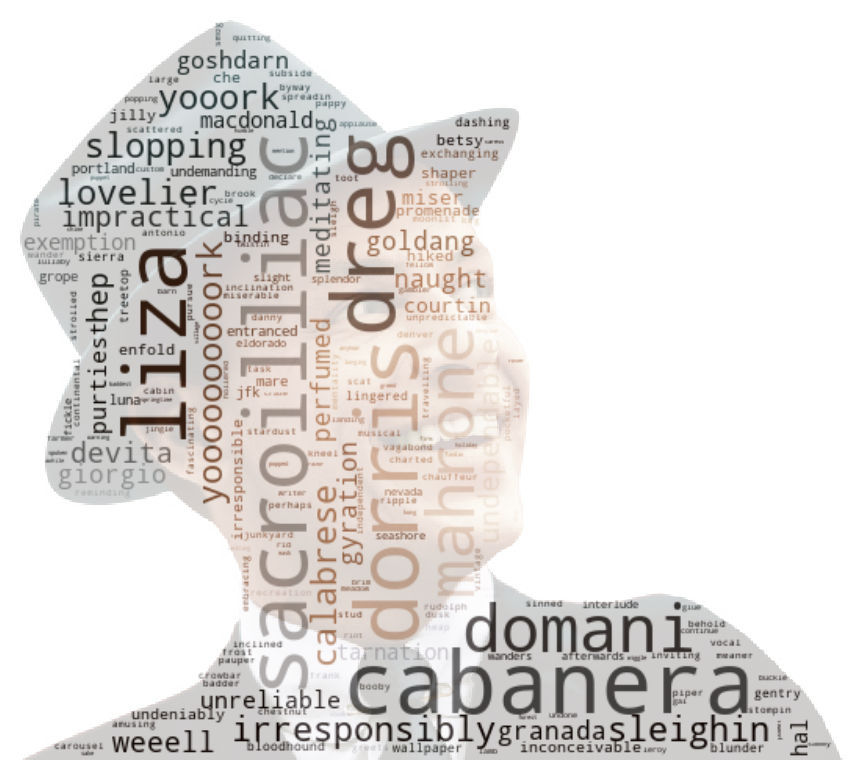

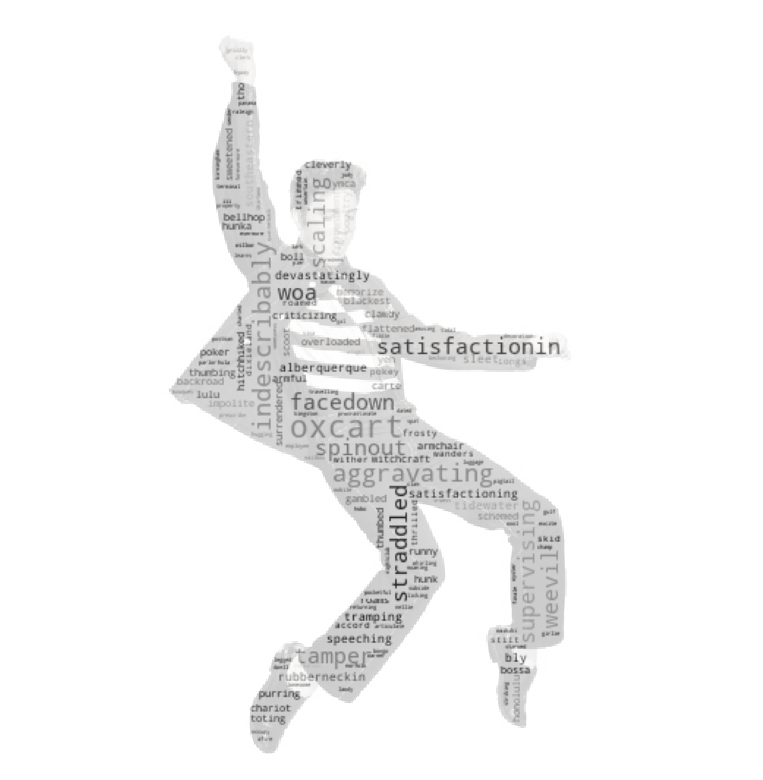

In [ ]:
for i, artist in enumerate(artist_ims.keys()):
    fdist = nltk.FreqDist(artist_docs[artist])
    artist_tfidf = {t: fdist.freq(t) * idf_dict[t] for t in set(artist_docs[artist])}
    wc = WordCloud(background_color='white', mask=artist_ims[artist]) # , color_func=MyColorFunctor(decade_tfidf)
    wc.generate_from_frequencies(artist_tfidf)
    image_colors = ImageColorGenerator(artist_ims[artist])
    plt.figure(dpi=200)
    plt.imshow(wc.recolor(color_func=image_colors), interpolation='bilinear')
    im = convertImage(f"wordcloud_masks/artists/{artist}.jpg")
    plt.imshow(im, interpolation='nearest', alpha=0.2)
    #plt.title(artist, size=20)
    plt.axis("off")
    plt.tight_layout()
    plt.savefig('wordclouds/artists/' + artist.replace(' ', '_') + '.png', bbox_inches='tight')
    plt.show()

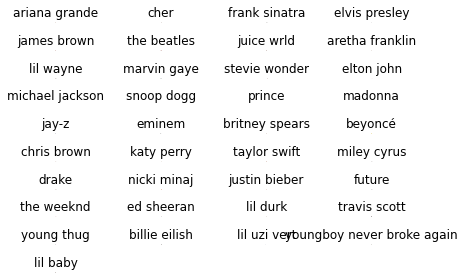

In [19]:
plt.figure()
for i, artist in enumerate(artist_ims.keys()):
    fdist = nltk.FreqDist(artist_docs[artist])
    artist_tfidf = {t: fdist.freq(t) * idf_dict[t] for t in set(artist_docs[artist])}
    wc = WordCloud(background_color='white', mask=artist_ims[artist]) # , color_func=MyColorFunctor(decade_tfidf)
    wc.generate_from_frequencies(artist_tfidf)
    image_colors = ImageColorGenerator(artist_ims[artist])
#     if i < ((n_decades+1)//2):
#         ax = plt.subplot(gs[0, 2 * i:2 * i + 2])
#     else:
#         ax = plt.subplot(gs[1, 2 * i - n_decades:2 * i + 2 - n_decades])
    plt.subplot(10, 4, i+1)
    plt.imshow(wc.recolor(color_func=image_colors), interpolation='bilinear')
    plt.title(artist)
    plt.axis("off")
plt.tight_layout()
plt.savefig('artist_clouds.pdf')
plt.show()

### Sentiment analysis

In [10]:
artist_happiness = {}

for artist, doc in artist_docs.items():
    artist_happiness[artist] = text_happiness_score(doc)

In [11]:
artist_happiness = {k: v for k, v in sorted(artist_happiness.items(), key=lambda item: item[1])}

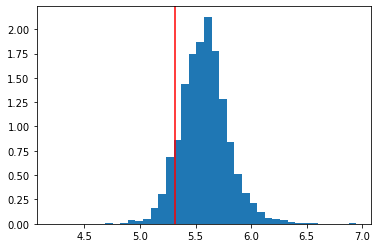

In [12]:
plt.figure()
plt.hist(artist_happiness.values(), bins=40, density=True)
plt.axvline(artist_happiness['eminem'], c='r')
plt.show()

### Lexical diveristy

In [13]:
all_tokens_raw = []
for t in songData.lyrics:
    tokens = list(token.lower() for token in nltk.word_tokenize(t) if token.isalpha())
    all_tokens_raw.append(tokens)

In [14]:
songData['tokens_raw'] = all_tokens_raw

In [15]:
artist_docs_raw = defaultdict(lambda: [])

for tokens, artists in zip(songData.tokens_raw, songData.artists):
    for artist in artists:
        artist_docs_raw[artist] += tokens

top_artist_docs_raw = {artist: doc for artist, doc in artist_docs_raw.items() if artist in top_artists}

In [211]:
top_artist_docs_repeat = defaultdict(lambda: [])

for tokens, artists in zip(songData.tokens_repeat, songData.artists):
    for artist in artists:
        if artist in top_artists:
            top_artist_docs_repeat[artist] += tokens

In [212]:
artist_lexi = {artist: lexical_diversity(doc) for artist, doc in top_artist_docs.items()}
artist_lexi = {k: v for k, v in sorted(artist_lexi.items(), key=lambda item: item[1], reverse=True)}

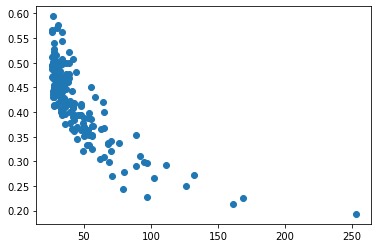

In [29]:
counts = [artist_count[k] for k in artist_lexi.keys()]
lexi = list(artist_lexi.values())

plt.figure()
plt.scatter(counts, lexi)
plt.show()

In [16]:
artist_lix = {artist: len(''.join(doc))/len(doc) for artist, doc in artist_docs_raw.items()}
artist_lix = {k: v for k, v in sorted(artist_lix.items(), key=lambda item: item[1], reverse=True)}

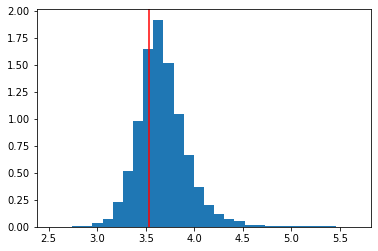

In [21]:
plt.figure()
plt.hist(artist_lix.values(), bins=30, density=True)
plt.axvline(artist_lix['justin bieber'], c='r')
plt.show()

### LSA

In [13]:
token_count = defaultdict(lambda: 0)

for tokens in songData.tokens:
    for token in tokens:
        token_count[token] += 1

vocabulary = list(token for token, count in token_count.items())
print('Words in vocabulary:', len(vocabulary))
word2id = {word: i for i, word in enumerate(vocabulary)}

Words in vocabulary: 50697


In [14]:
# vocabulary = set()
# for doc in top_artist_docs.values():
#     vocabulary = vocabulary.union(set(doc))
# vocab_size = len(vocabulary)

In [15]:
artist_docs_set = {artist: set(doc) for artist, doc in artist_docs.items()}
idf_dict = {t: idf(t, artist_docs_set) for t in vocabulary}

In [35]:
artist2id = {artist: i for i, artist in enumerate(artist_docs.keys())}
id2artist = {i: artist for i, artist in enumerate(artist_docs.keys())}
term_artist_mat = np.zeros((len(artist_docs.keys()), len(vocabulary)))
for artist, doc in artist_docs.items():
    fdist = nltk.FreqDist(doc)
    for t in set(doc):
        term_artist_mat[artist2id[artist], word2id[t]] = fdist.freq(t) * idf_dict[t]

In [17]:
term_artist_mat

array([[0.0034371 , 0.00160827, 0.00131821, ..., 0.        , 0.        ,
        0.        ],
       [0.00404016, 0.00180453, 0.00098605, ..., 0.        , 0.        ,
        0.        ],
       [0.00498392, 0.00233206, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.00250916, 0.00136976, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00169885, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.00135447, 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [36]:
def cosinesimilarity(vec1, vec2):
    return vec1@vec2 / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

def similar(artist_vec, doc_term_matrix, artist=None, n=5):
    artist_id = artist2id[artist] if artist is not None else -1
    top_n_sim = [(None, -1) for _ in range(n)]
    for i, artist_b_vec in enumerate(doc_term_matrix):
        if i == artist_id:
            continue
        similarity = cosinesimilarity(artist_vec, artist_b_vec)
        if similarity > min(top_n_sim, key=lambda x: x[1])[1]:
            top_n_sim[-1] = (id2artist[i], similarity)
            top_n_sim = sorted(top_n_sim, key=lambda x: x[1], reverse=True)
            
    return top_n_sim

In [51]:
artist = 'bee gees'
artist_vec = term_artist_mat[artist2id[artist]]
similar(artist_vec, term_artist_mat, artist=artist, n=5)

[('dionne warwick', 0.52579494130065),
 ('taylor swift', 0.5200786299476331),
 ('elvis presley', 0.5189147084068425),
 ('cher', 0.5112107252530914),
 ('diana ross', 0.5078886761288735)]

In [32]:
all_all_tokens = list()
for t in songData.lyrics:
    all_all_tokens += [token for token in nltk.word_tokenize(t) if token.isalpha() or token.isdigit()]

print(len(all_all_tokens))

8486901
